**Table of contents**<a id='toc0_'></a>    
- [Initial Tests](#toc1_)    
- [Using minimize from scipy.optimize](#toc2_)    
- [Using PyTorch](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Initial Tests](#toc0_)

In [1]:
#from optic.models.devices import mzm, pm
#from optic.utils import parameters
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

π = np.pi
SpS = 64            # Amostras por símbolo
Rs  = 10e9          # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

t = np.arange(0, SpS*500)*Ta

Vπ = 2
P = 1
n_peaks = 11


In [2]:
def pm(Ai, u, Vπ):
    return Ai*np.cos(u/Vπ*np.pi) + 1j*Ai*np.sin(u/Vπ*np.pi)

def mzm(Ai, u, Vπ, Vb):
    return Ai * np.cos(0.5 / Vπ * (u + Vb) * np.pi)

def ddmzm(Ai, u1, u2, Vb1, Vb2, Vπ):
    return 0.5 * Ai * (pm(1, u1 + Vb1, Vπ) + pm(1, u2 + Vb2, Vπ)) 

In [3]:
def frequencyCombGenerator(V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2):
    u1 = V1 * np.cos(2 * π * Rs * t + Phase1)
    u2 = V2 * np.cos(2 * π * Rs * t + Phase2)
    u3 = V3 * np.cos(2 * π * Rs * t + Phase3)
    
    '''
    par1 = parameters()
    par1.Vpi = Vπ
    par1.Vb = Vb1

    par2 = parameters()
    par2.Vpi = Vπ
    par2.Vb = Vb2

    frequency_comb = P
    frequency_comb = mzm(frequency_comb, u1, par1)
    frequency_comb = mzm(frequency_comb, u2, par2)
    frequency_comb =  pm(frequency_comb, u3, Vπ)
    '''

    frequency_comb = P
    frequency_comb = mzm(frequency_comb, u1, Vπ, Vb1)
    frequency_comb = mzm(frequency_comb, u2, Vπ, Vb2)
    frequency_comb =  pm(frequency_comb, u3, Vπ)

    return frequency_comb

In [4]:
def frequencyCombGenerator_DDMZM(V1, V2, Phase1, Phase2, Vb1, Vb2):
    u1 = V1 * np.cos(2 * π * Rs * t + Phase1)
    u2 = V2 * np.cos(2 * π * Rs * t + Phase2)
    
    frequency_comb = ddmzm(P, u1, u2, Vb1, Vb2, Vπ)

    return frequency_comb

In [5]:
def get_psd_ByFFT(signal, Fa, NFFT = 16*1024):
    
    fft_result = np.fft.fftshift(np.fft.fft(signal, NFFT))
    power_spectrum = np.abs(fft_result)**2
    psd = power_spectrum / (NFFT*Fa)
    freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, 1 / Fa))

    #min_psd = np.min(psd[psd != 0])
    min_psd = 10e-100
    psd[psd == 0] = min_psd
    
    return psd, freqs

In [80]:
t = np.arange(0, SpS*1000)*Ta
V1 = 1
V2 = 1
Phase1 = 0
Phase2 = 0
u1 = V1 * np.cos(2 * π * Rs * t + Phase1)
u2 = V2 * np.cos(2 * π * Rs * t + Phase2)

%timeit pm(P, u1, Vπ)
%timeit mzm(P, u1, Vπ, 0)
%timeit ddmzm(P, u1, u2, 0, 0, Vπ)

print('')
t = np.arange(0, SpS*500)*Ta
V1 = 1
V2 = 1
Phase1 = 0
Phase2 = 0
u1 = V1 * np.cos(2 * π * Rs * t + Phase1)
u2 = V2 * np.cos(2 * π * Rs * t + Phase2)

%timeit pm(P, u1, Vπ)
%timeit mzm(P, u1, Vπ, 0)
%timeit ddmzm(P, u1, u2, 0, 0, Vπ)

1.02 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
255 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.81 ms ± 453 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

421 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
125 µs ± 877 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.02 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [85]:
signal = frequencyCombGenerator(1, 1, 1, 0, 0, 0, 0, 0)
%timeit get_psd_ByFFT(signal, Fa, 16*1024)
%timeit get_psd_ByFFT(signal, Fa, 20*1024)

459 µs ± 65.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
594 µs ± 65.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
def get_indx_peaks(log_Pxx, n_peaks):
    indx = find_peaks(log_Pxx, height=(-330, 0))[0]
    discard = (indx.size - n_peaks)
    indx = indx[int(np.floor(discard/2)): -int(np.ceil(discard/2))]
    return indx

In [6]:
def plot_signalPower_and_frequencyComb(V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2):

    frequencyComb = frequencyCombGenerator(V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2)

    _, ax = plt.subplots(1,3,figsize = (15,3));
    ax[0].plot(t[:SpS*4]*1e9, abs(frequencyComb[:SpS*4])**2, label = "Optical Signal")
    ax[0].set_xlabel("Time (ns)")
    ax[0].set_ylabel("Power (W)")
    ax[0].set_xlim(0,4*Ts*1e9)
    ax[0].set_ylim(0,1)
    ax[0].legend(loc='upper right')
    ax[0].grid()
    
    Pxx, freqs = get_psd_ByFFT(frequencyComb, Fa)
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)

    ax[1].plot(freqs, log_Pxx, label = "Optical Signal Spectrum")
    ax[1].plot(freqs[indx], log_Pxx[indx], 'o')
    ax[1].set_xlim(-20*Rs,20*Rs);
    ax[1].set_ylim(-200,-80);
    ax[1].legend(loc='lower right');
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate");
    ax[1].set_ylabel("Power (dB)");
    ax[1].grid()
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx])
    ax[1].plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    ax[1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    ax[1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")

    ax[2].axis('off')
    ax[2].text(0, 0.7, "Mean: %.2f dB" %mean, fontsize=10)
    ax[2].text(0, 0.6, "Standard Deviation: %.2f dB" %np.sqrt(var), fontsize=10)
    ax[2].text(0, 0.4, "Variance: %.2f dB^2"%var, fontsize=12)
    ax[2].text(0, 0.3, "max - min: %.2f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])), fontsize=12)

    plt.tight_layout()

In [7]:
import ipywidgets as widgets

V_min = 0
V_max = 5.0
Phase_min = 0.0
#Phase_max = 2.0*π
Phase_max = π/2
Vb_min = 0.0
#Vb_max = 4.0*Vπ
Vb_max = Vπ

initial_values = [2.08523453e+00,  1.92173568e+00,  2.38367504e+00,  1.24705160e+00, 7.63698398e-01,  8.05195271e-01,  2.00000000e+00, -8.06552115e-21]

V1 = widgets.FloatSlider(value=initial_values[0], min=V_min, max=V_max,step = 0.001, description = 'V1')
V2 = widgets.FloatSlider(value=initial_values[1], min=V_min, max=V_max,step = 0.001, description = 'V2')
V3 = widgets.FloatSlider(value=initial_values[2], min=V_min, max=V_max,step = 0.001, description = 'V3')
Phase1 = widgets.FloatSlider(value=initial_values[3], min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase1')
Phase2 = widgets.FloatSlider(value=initial_values[4], min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase2')
Phase3 = widgets.FloatSlider(value=initial_values[5], min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase3')
Vb1 = widgets.FloatSlider(value=initial_values[6], min=Vb_min, max=Vb_max,step = 0.001, description = 'Vb1')
Vb2 = widgets.FloatSlider(value=initial_values[7], min=Vb_min, max=Vb_max,step = 0.001, description = 'Vb2')

ui1 = widgets.HBox([V1, V2, V3, Vb1])
ui2 = widgets.HBox([Phase1, Phase2, Phase3, Vb2])
out1 = widgets.interactive_output(plot_signalPower_and_frequencyComb, {'V1': V1, 'V2': V2,'V3':V3,'Phase1':Phase1, 'Phase2':Phase2, 'Phase3':Phase3,'Vb1': Vb1, 'Vb2': Vb2})

display(ui1, ui2,out1)

Output()

# <a id='toc2_'></a>[Using minimize from scipy.optimize](#toc0_)

In [8]:
from scipy.optimize import minimize

# Função objetivo a ser minimizada
def objective_function(params):
    
    frequencyComb = frequencyCombGenerator(*params)

    Pxx, _ = get_psd_ByFFT(frequencyComb, Fa)
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    var = np.var(log_Pxx[indx])
    target_var = 0
    
    # Objetivo: planificar os picos
    return (var - target_var)**2
 

In [9]:
# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [2.0, 1.9, 1.5, 0.3, 0.75, 0.8, 2.0, 0.0]

V_min = 0.0
V_max = 3.0
Phase_min = 0.0
#Phase_max = 2*π
Phase_max = π/2
Vb_min = 0.0
#Vb_max = 4*Vπ
Vb_max = Vπ

bounds = [(V_min,V_max),(V_min,V_max),(V_min,V_max),(Phase_min, Phase_max),(Phase_min, Phase_max),(Phase_min, Phase_max),(Vb_min,Vb_max),(Vb_min,Vb_max)]

# Realizar a otimização
method = ["Nelder-Mead", "L-BFGS-B", "TNC", "SLSQP", "Powell", "trust-constr", "COBYLA"]
result = minimize(objective_function, initial_guess, method=method[6],bounds = bounds)
optimized_params = result.x

V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.4f} V")
print(f"V2: {V2:.4f} V")
print(f"V3: {V3:.4f} V")
print(f"Phase1: {Phase1:.4f} rad")
print(f"Phase2: {Phase2:.4f} rad")
print(f"Phase3: {Phase3:.4f} rad")
print(f"Vb1: {Vb1:.4f} V")
print(f"Vb2: {Vb2:.4f} V")

Configurações otimizadas:
V1: 2.0852 V
V2: 1.9217 V
V3: 2.3837 V
Phase1: 1.2471 rad
Phase2: 0.7637 rad
Phase3: 0.8052 rad
Vb1: 2.0000 V
Vb2: -0.0000 V


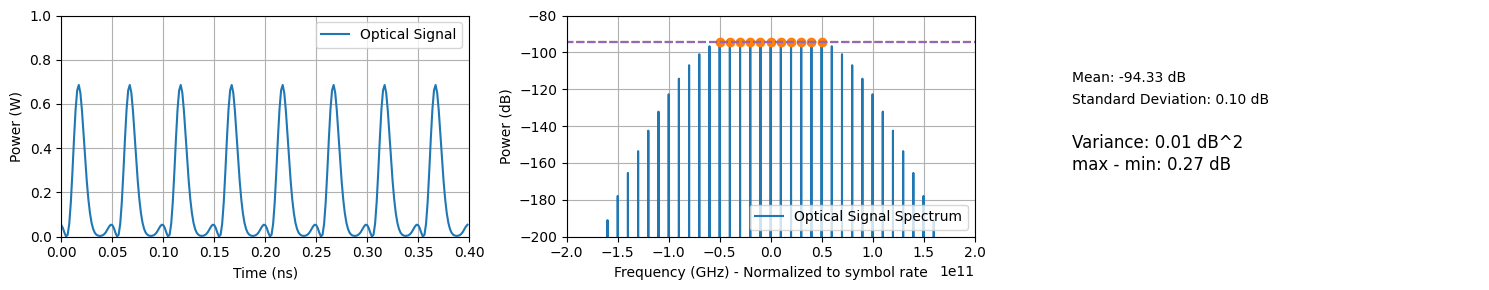

In [10]:
plot_signalPower_and_frequencyComb(*optimized_params)

# <a id='toc3_'></a>[Using PyTorch](#toc0_)

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [8]:
def frequencyCombPeaks(params):
    
    frequency_comb = frequencyCombGenerator(*params)
    Pxx, _ = get_psd_ByFFT(frequency_comb, Fa)
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)

    return log_Pxx[indx].tolist()

In [9]:
class FrequencyCombNet(nn.Module):
    def __init__(self, architecture):
        self.architecture = architecture
        super(FrequencyCombNet, self).__init__()
        layers = [nn.Linear(architecture[0], architecture[1])]
        for i in range(1, len(architecture) - 1):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(architecture[i], architecture[i + 1]))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [10]:

# Define your custom dataset
class FrequencyCombDataset(Dataset):
    def __init__(self, myfunction, nsamples, bounds, norm_scale = 1, zero_mean = False):
        self.nsamples = nsamples
        self.bounds = bounds
        self.norm_scale = norm_scale
        self.zero_mean = zero_mean
        samples = [[urand.Uniform(low, high).sample().item() for low, high in self.bounds] for _ in range(self.nsamples)]
      
        self.input_tensors = torch.from_numpy(np.array(samples)).float()
        
        self.output_tensors = []
        for sample in samples:
            freq_peaks = myfunction(sample)
            if zero_mean:
                freq_peaks = freq_peaks - np.mean(freq_peaks)
            self.output_tensors.append(freq_peaks)
        self.output_tensors = torch.from_numpy(np.array(self.output_tensors)).float()
        
        if norm_scale == 1:
            self.norm_scale = torch.ceil(torch.max(torch.abs(self.output_tensors))).item()
        self.output_tensors = self.normalize(self.output_tensors)
        

    def __len__(self):
        return len(self.input_tensors)
    
    def data_size(self):
        inputs_size_in_bytes = self.input_tensors.nelement() * self.input_tensors.element_size()/1024
        outputs_size_in_bytes = self.output_tensors.nelement() * self.output_tensors.element_size()/1024
        return inputs_size_in_bytes + outputs_size_in_bytes
    
    def normalize(self, tensor):
        if self.zero_mean:
            norm_tensor = (tensor + self.norm_scale) / (2* self.norm_scale)
        else:
            norm_tensor = tensor / self.norm_scale
        return norm_tensor
    
    def denormalize(self, tensor):
        if self.zero_mean:
            denorm_tensor = tensor * 2* self.norm_scale - self.norm_scale
        else:
            denorm_tensor = tensor * self.norm_scale
        return denorm_tensor
    
    def __getitem__(self, idx):
        return self.input_tensors[idx], self.output_tensors[idx]

In [11]:
V_min = 0.1
V_max = 3
Phase_min = 0
Phase_max = 2*π
Vb_min = 0
Vb_max = 4*Vπ

bounds = [(V_min,V_max),(V_min,V_max),(V_min,V_max), (Phase_min, Phase_max),(Phase_min, Phase_max), (Phase_min, Phase_max), (Vb_min,Vb_max), (Vb_min,Vb_max)]
#bounds = [(V_min,V_max),(V_min,V_max), (Phase_min, Phase_max),(Phase_min, Phase_max), (Vb_min,Vb_max), (Vb_min,Vb_max)]

train_nsamples = 300000
test_nsamples  = 30000
val_nspamples  = 30000
n_peaks = 11

#Trying to use CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Runnning in {device}")

Runnning in cuda


In [12]:
#load datasets if they exist, create them otherwise

dataset_name = f"mzm_mzm_pm_{train_nsamples*1e-3:.0f}k_sampless"
train_filename = "saved_data/datasets/train_dataset_" + dataset_name + ".pt"
test_filename = "saved_data/datasets/test_dataset_" + dataset_name + ".pt"
val_filename = "saved_data/datasets/val_dataset_" + dataset_name + ".pt"
if os.path.exists(train_filename) and os.path.exists(test_filename) and os.path.exists(val_filename):
    print("Loading datasets...")
    train_dataset = torch.load(train_filename)
    test_dataset = torch.load(test_filename)
    val_dataset = torch.load(val_filename)
    print("Datasets loaded!")
else:
    print("Creating datasets...")
    train_dataset = FrequencyCombDataset(frequencyCombPeaks, train_nsamples, bounds, zero_mean=True)
    test_dataset = FrequencyCombDataset(frequencyCombPeaks, test_nsamples, bounds, train_dataset.norm_scale, train_dataset.zero_mean)
    val_dataset = FrequencyCombDataset(frequencyCombPeaks, val_nspamples, bounds, train_dataset.norm_scale, train_dataset.zero_mean)
    print("Datasets created!")

    torch.save(train_dataset, train_filename)
    torch.save(test_dataset, test_filename)
    torch.save(val_dataset, val_filename)
    print("Datasets saved!")

Loading datasets...
Datasets loaded!


In [13]:
print(f"Train Dataset Size: {train_dataset.data_size():.2f} kB")
print(f"Test Dataset Size: {test_dataset.data_size():.2f} kB")
print(f"Validation Dataset Size: {val_dataset.data_size():.2f} kB")

Train Dataset Size: 22265.62 kB
Test Dataset Size: 2226.56 kB
Validation Dataset Size: 2226.56 kB


In [14]:
# Create data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, pin_memory=True)

In [15]:
# Initialize the model
n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]
architecture = [n_inputs, 128, 256, 512, 256, 128, n_outputs]

model = FrequencyCombNet(architecture).to(device)
model_name = "model_" + "_".join([f"{n:.0f}" for n in architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"
model_path = "saved_data/models/"+ model_name +".pth"

# load model
if os.path.exists(model_path):
    print("Loading model...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print("Model loaded!")
else:
    print("No model found!")
    print("Model created!")

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # lr - learning rate

Loading model...
Model loaded!


In [16]:
def convert_to_real_loss(loss):
    loss = np.array(loss)
    if train_dataset.zero_mean:
        loss = loss * (2 * train_dataset.norm_scale)**2
    else:
        loss = loss * (train_dataset.norm_scale)**2
    return loss.squeeze()

In [17]:
def plot_training_progress(train_losses, val_losses, title = "Training and Validation Losses", ylabel = "Loss", average_curves = False, M = 200):

    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    plt.figure(figsize=(15,5))
    plt.plot(train_losses, label=f'Training Loss: {train_losses[-1]:.4f}', color = "C0")
    plt.plot(val_losses, label=f'Validation Loss: {val_losses[-1]:.4f}', color='C3')

    if train_losses.size > M and average_curves:
        def moving_average(x, w):
            return np.convolve(x, np.ones(w), 'valid')/w
        plt.plot(moving_average(train_losses, M), color='blue', label='Training Loss (Moving Average)')
        plt.plot(moving_average(val_losses, M), color='red', label='Validation Loss (Moving Average)')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(which='both', alpha=0.5)
    plt.minorticks_on()
    plt.show()

In [18]:
# Training loop

## losses

train_losses_path = "saved_data/losses/" + model_name + '_train_losses.npy'
val_losses_path = "saved_data/losses/" + model_name + '_val_losses.npy'

# Load training losses if file exists
if os.path.exists(train_losses_path) and os.path.exists(val_losses_path):
    train_losses = list(np.load(train_losses_path))
    val_losses = list(np.load(val_losses_path))
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

Losses files loaded!


## Forward Network

Epoch: 100/1000.. Training loss: 2.786941 (dB/Hz)^2.. Validation Loss: 6.365878 (dB/Hz)^2


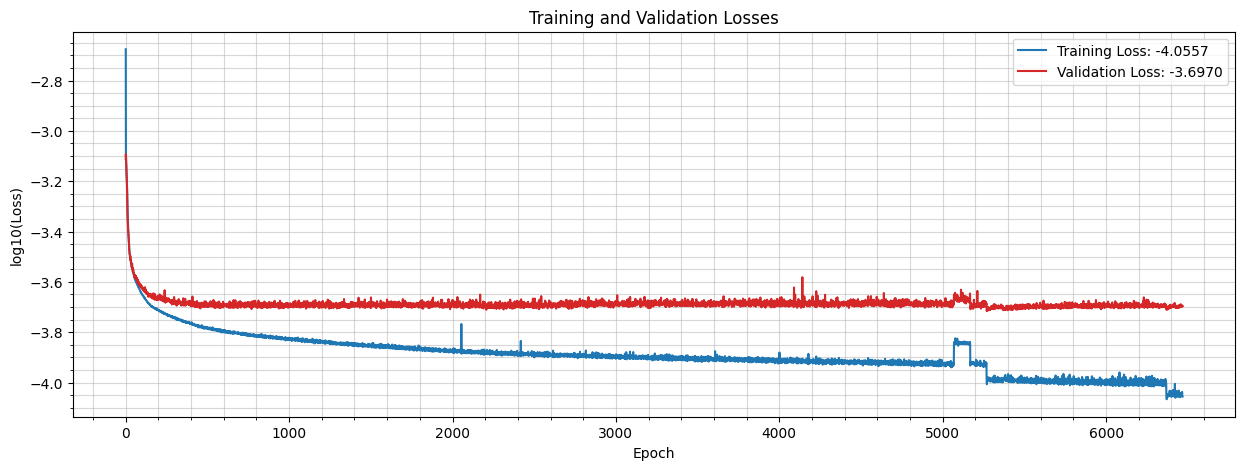

Epoch: 200/1000.. Training loss: 2.831977 (dB/Hz)^2.. Validation Loss: 6.410237 (dB/Hz)^2


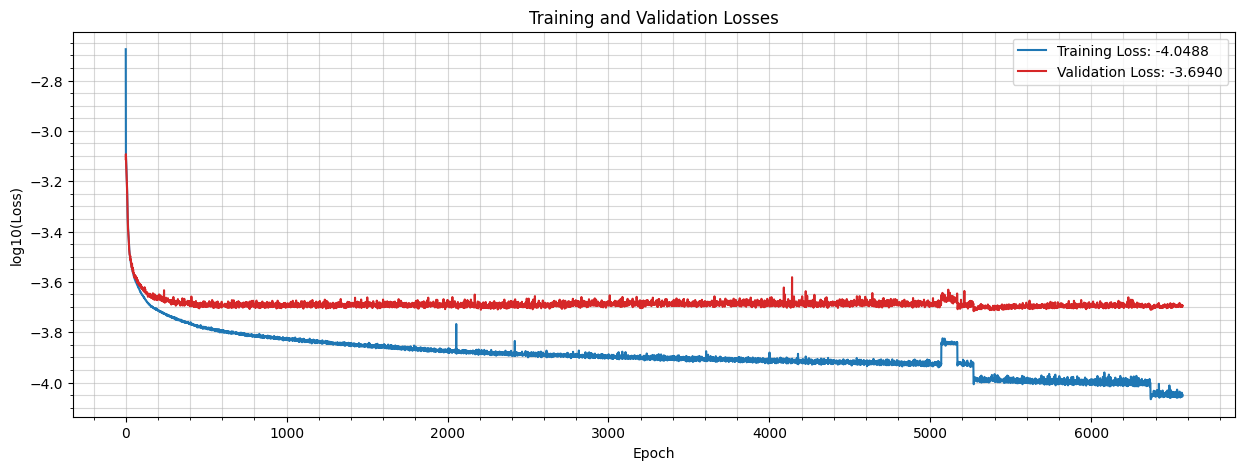

Epoch: 300/1000.. Training loss: 2.786338 (dB/Hz)^2.. Validation Loss: 6.371518 (dB/Hz)^2


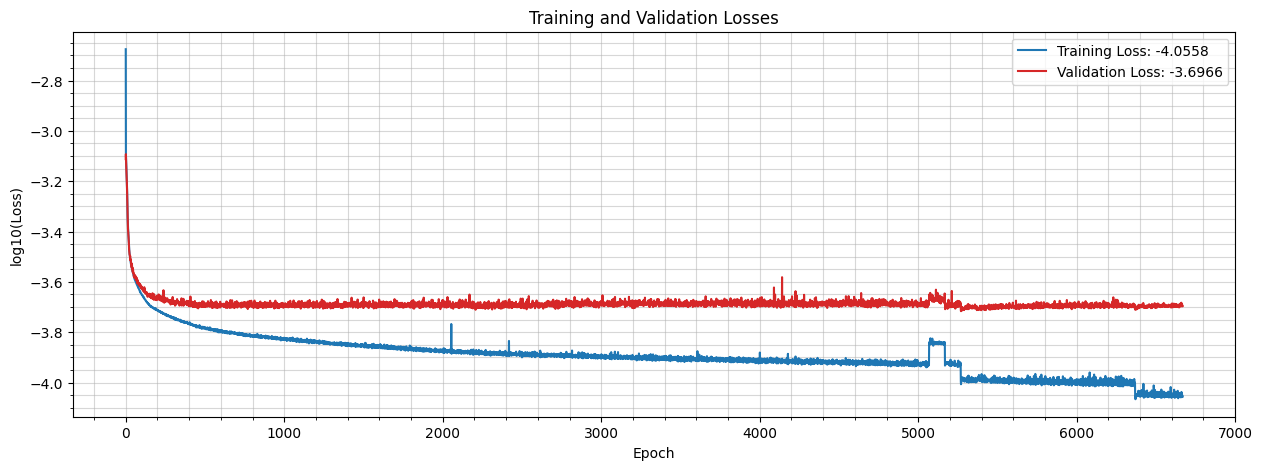

Epoch: 400/1000.. Training loss: 2.773656 (dB/Hz)^2.. Validation Loss: 6.378437 (dB/Hz)^2


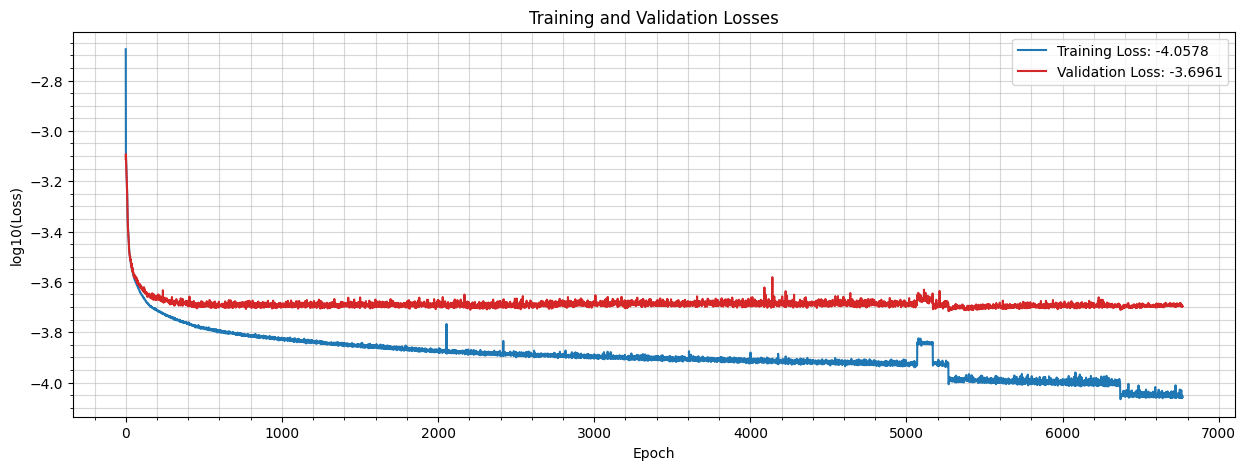

Epoch: 500/1000.. Training loss: 2.787598 (dB/Hz)^2.. Validation Loss: 6.449029 (dB/Hz)^2


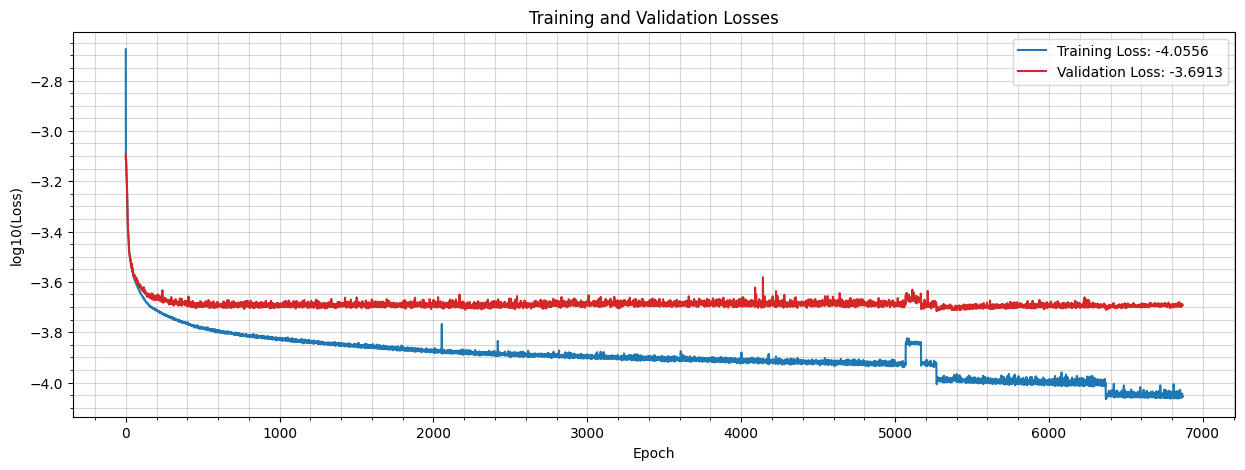

Epoch: 600/1000.. Training loss: 2.835009 (dB/Hz)^2.. Validation Loss: 6.477644 (dB/Hz)^2


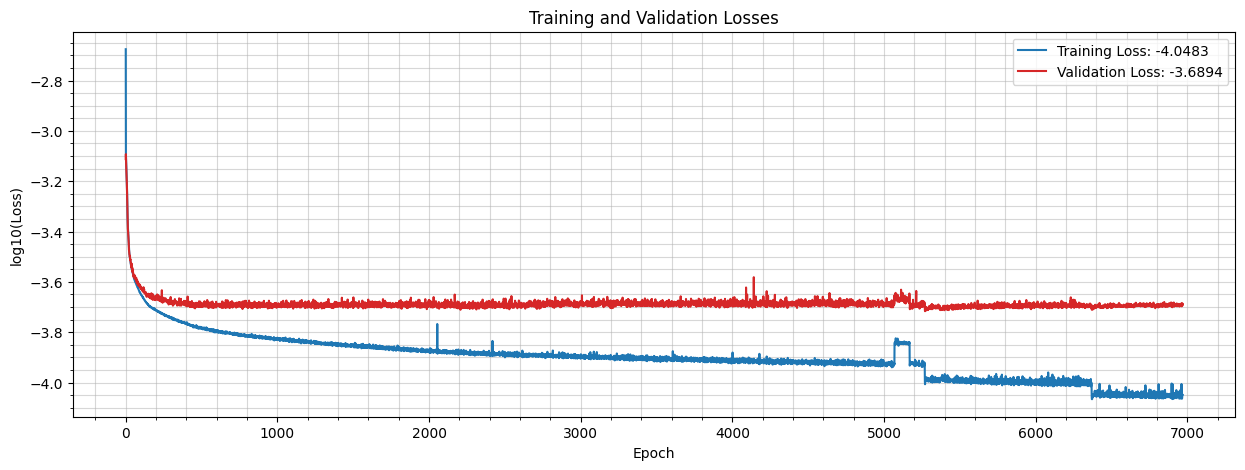

Epoch: 700/1000.. Training loss: 2.742097 (dB/Hz)^2.. Validation Loss: 6.478038 (dB/Hz)^2


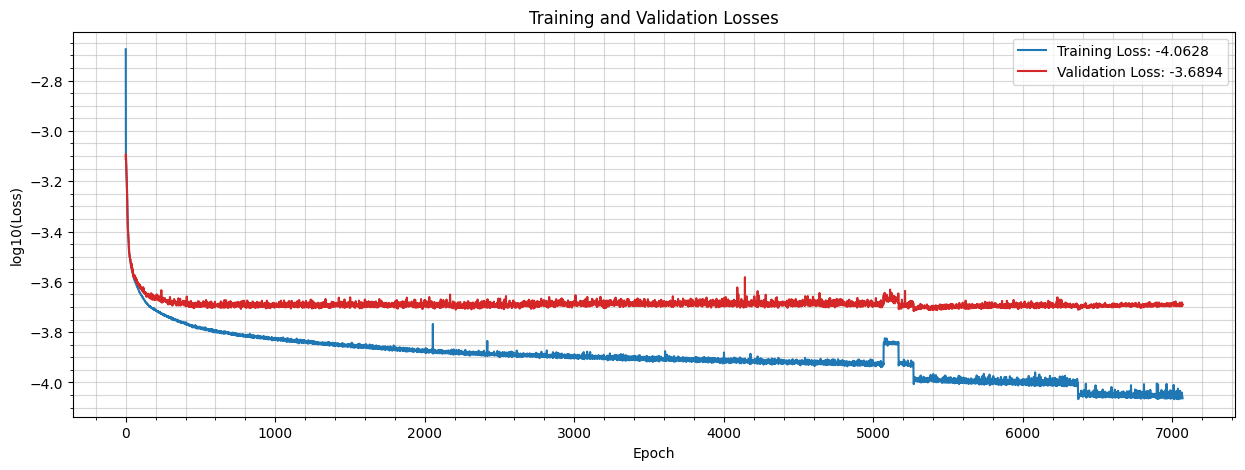

Epoch: 800/1000.. Training loss: 2.862279 (dB/Hz)^2.. Validation Loss: 6.461930 (dB/Hz)^2


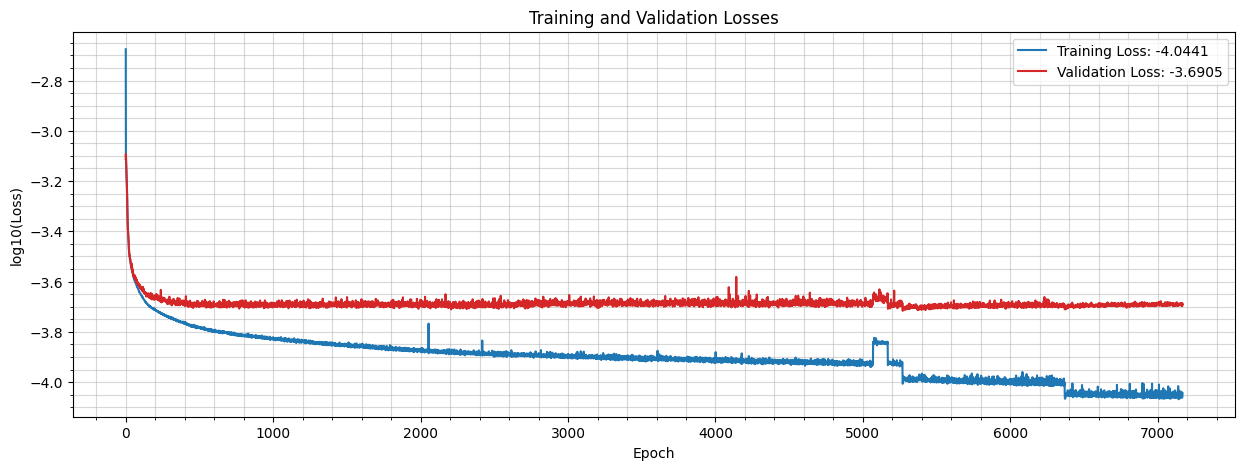

Epoch: 900/1000.. Training loss: 2.782120 (dB/Hz)^2.. Validation Loss: 6.464087 (dB/Hz)^2


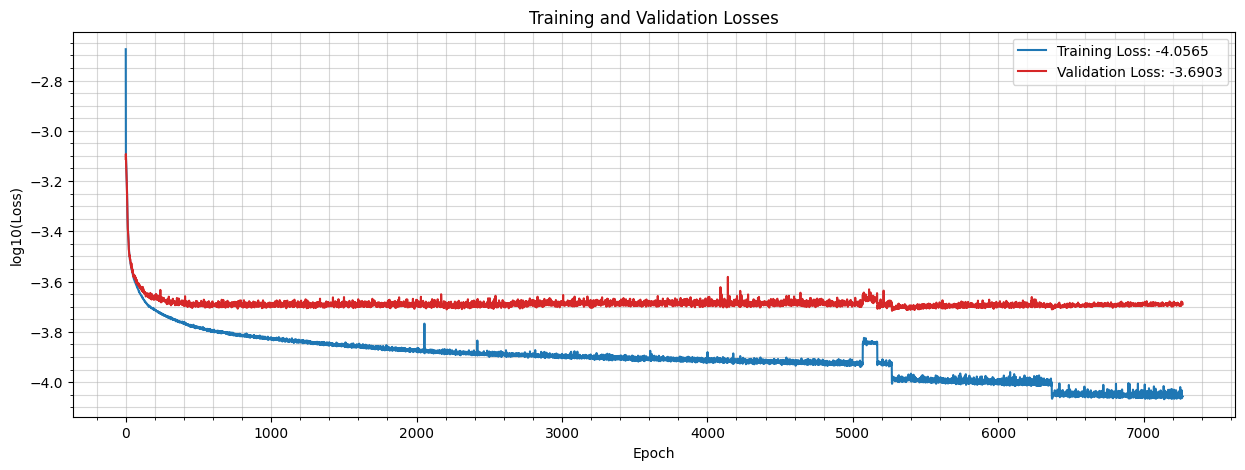

Epoch: 1000/1000.. Training loss: 2.789328 (dB/Hz)^2.. Validation Loss: 6.406587 (dB/Hz)^2


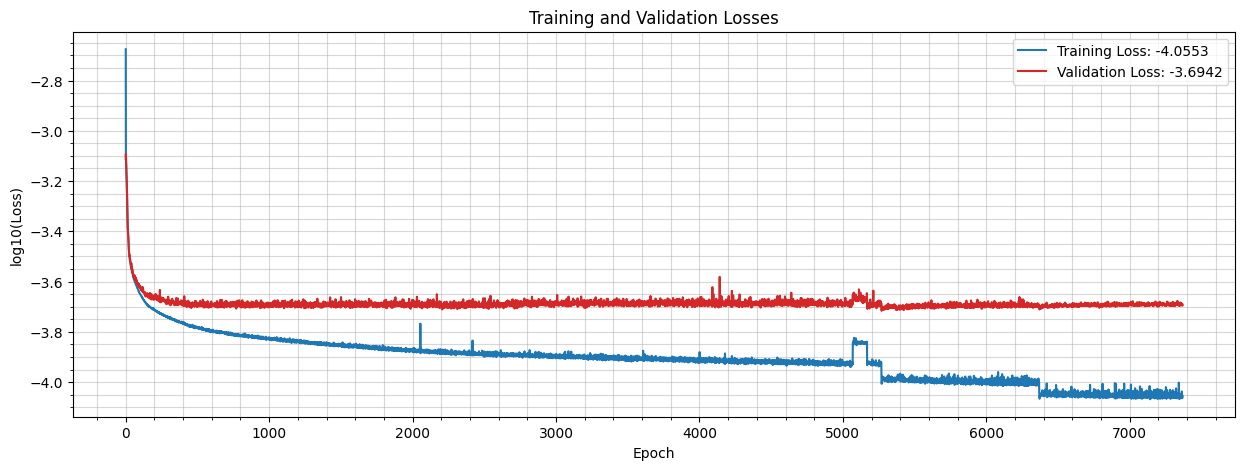

In [64]:
num_epochs = 1000
#val_loss_min = 1

for epoch in range(1, num_epochs + 1):

    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs) # Calculate outputs (forward pass)
        loss = criterion(outputs, targets) # Calculate loss

        # Backward pass
        loss.backward() # Calculate gradients
        optimizer.step() # Update weights

        running_loss += loss.item() * inputs.size(0) # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset) # Calculate average loss over an epoch
    train_losses.append(avg_train_loss) #Epoch training losses for plotting

    # Validation phase
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss) # Append average validation loss for the epoch

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {convert_to_real_loss(train_losses[-1]):.6f} (dB/Hz)^2.. Validation Loss: {convert_to_real_loss(val_losses[-1]):.6f} (dB/Hz)^2")
        #plot_training_progress(real_train_losses, real_val_losses, ylabel = "Loss (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), model_name + "val_min.pth")
        val_loss_min = avg_val_loss


In [67]:
# Save model
torch.save(model.state_dict(), model_path)

# Save training and validation losses
np.save(train_losses_path, np.array(train_losses))
np.save(val_losses_path, np.array(val_losses))


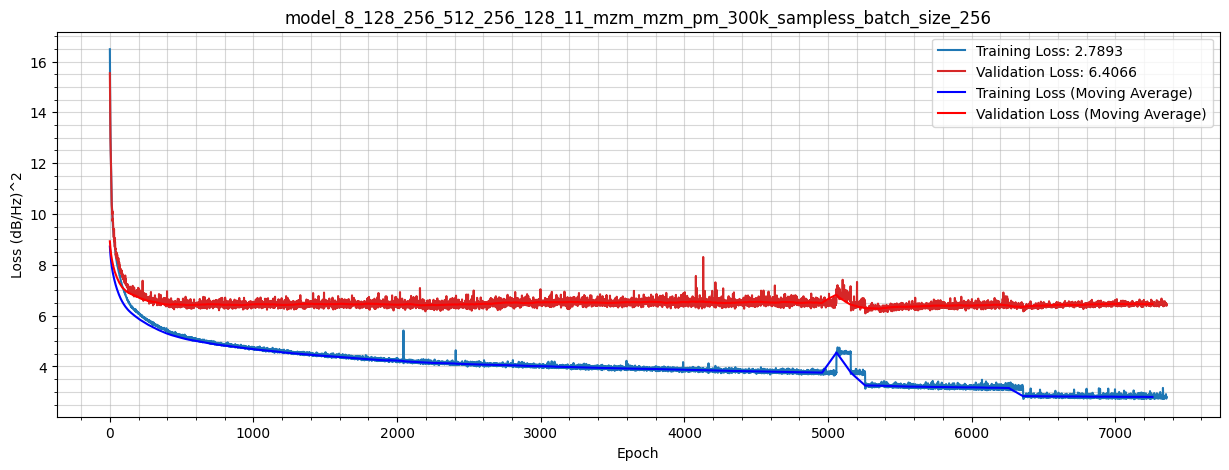

In [19]:
real_train_losses = convert_to_real_loss(train_losses)
real_val_losses = convert_to_real_loss(val_losses)
plot_training_progress(real_train_losses[10:], real_val_losses[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 100)

In [20]:
model.load_state_dict(torch.load(model_name + "val_min.pth"))
model.eval()

FrequencyCombNet(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=11, bias=True)
  )
)

Normalized Loss: 0.000017
Denormalized Loss: 0.542727 (dB/Hz)^2


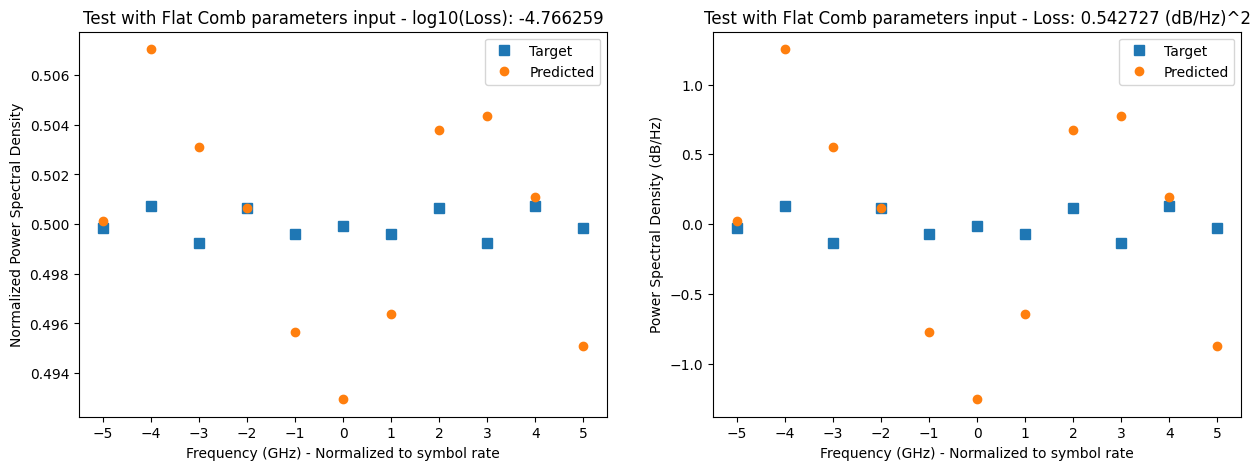

In [74]:
# Test with flat comb
model.eval() # Set model to evaluation mode
with torch.no_grad():
    params = [2.08523453e+00,  1.92173568e+00,  2.38367504e+00,  1.24705160e+00, 7.63698398e-01,  8.05195271e-01,  2.00000000e+00, -8.06552115e-21]# flat comb parameters
    #params = [4.06272973, 3.43462156, 1.56805446, 1.56803667, 2.97554328, 1.47611193] # Flat comb parameters

    input = torch.tensor(params, dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = torch.tensor(frequencyCombPeaks(params), dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = target_non_norm - torch.mean(target_non_norm)
    target = train_dataset.normalize(target_non_norm)
    output = model(input)
    
    #plot using subplots, side by side
    fig, ax = plt.subplots(1,2,figsize = (15,5))
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),output.squeeze().cpu().numpy(),"o", label='Predicted')
    ax[0].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[0].set_ylabel("Normalized Power Spectral Density")
    ax[0].legend()
    loss = criterion(output, target).item()
    ax[0].set_title(f'Test with Flat Comb parameters input - log10(Loss): {np.log10(loss):.6f}')

    print(f"Normalized Loss: {loss:.6f}")
    print(f"Denormalized Loss: {convert_to_real_loss(loss):.6f} (dB/Hz)^2")
    
    # Denormalize
    output = train_dataset.denormalize(output)
    target = train_dataset.denormalize(target)

    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),output.squeeze().cpu().numpy(),"o", label='Predicted')
    ax[1].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[1].set_ylabel("Power Spectral Density (dB/Hz)")
    ax[1].legend()
    #real_loss = convert_to_real_loss(loss)
    real_loss = criterion(output, target).item()
    ax[1].set_title(f'Test with Flat Comb parameters input - Loss: {real_loss:.6f} (dB/Hz)^2')   

In [75]:
# Test phase
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    running_test_loss = 0.0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss = criterion(outputs, targets)
        running_test_loss += test_loss.item() * inputs.size(0)
    avg_test_loss = running_test_loss / len(test_loader.dataset)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss):.6f} (dB/Hz)^2")

Test Loss: 6.147428 (dB/Hz)^2


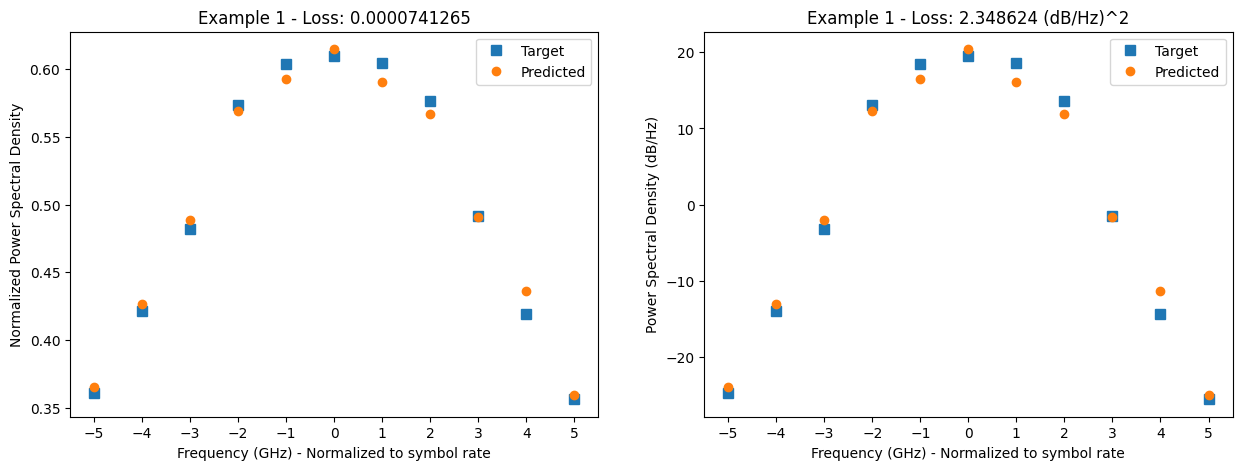

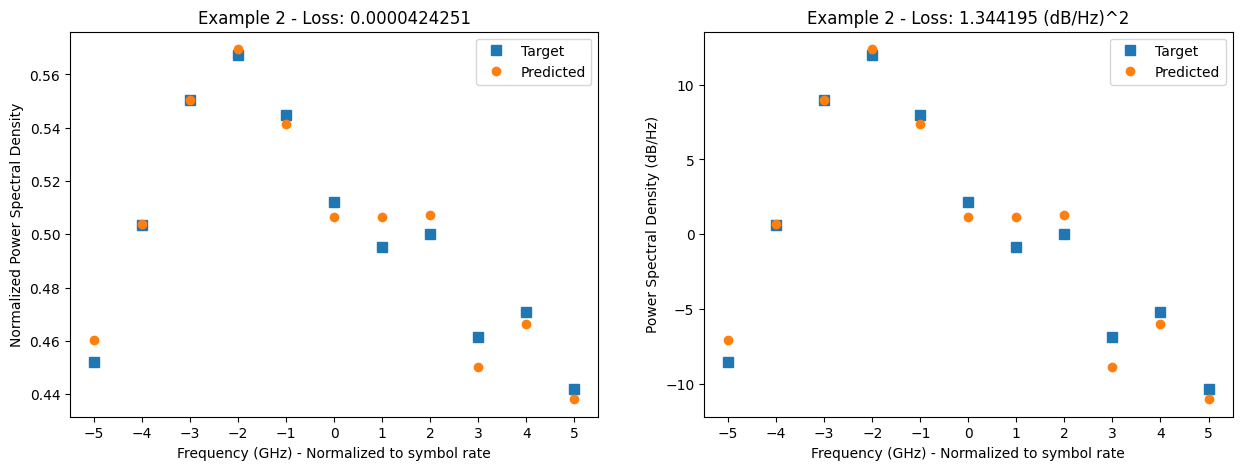

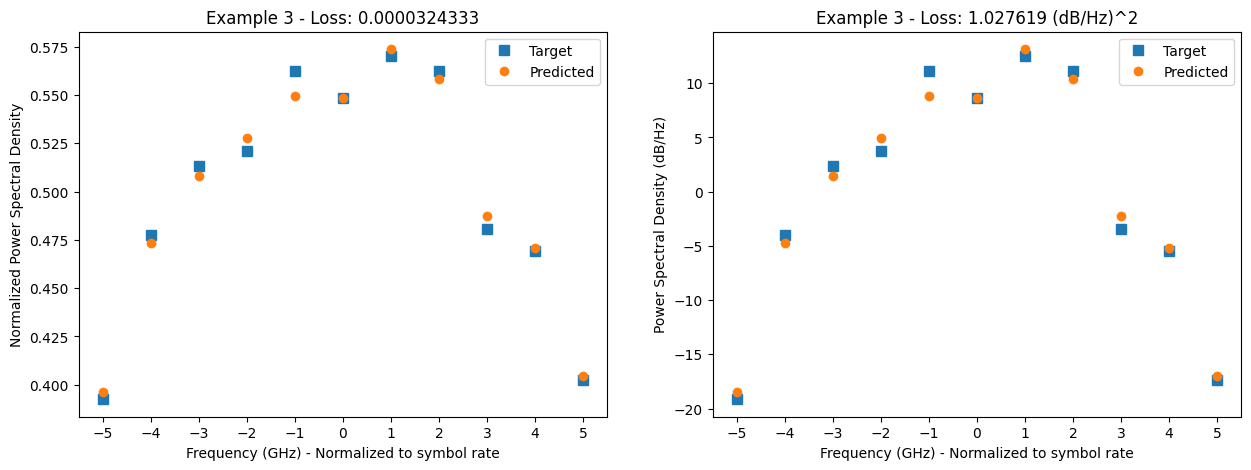

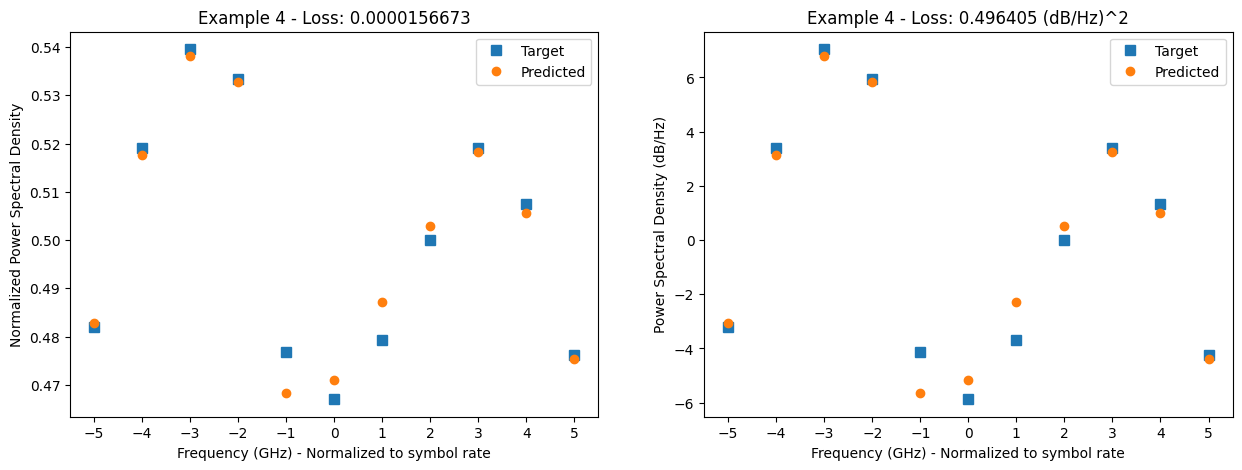

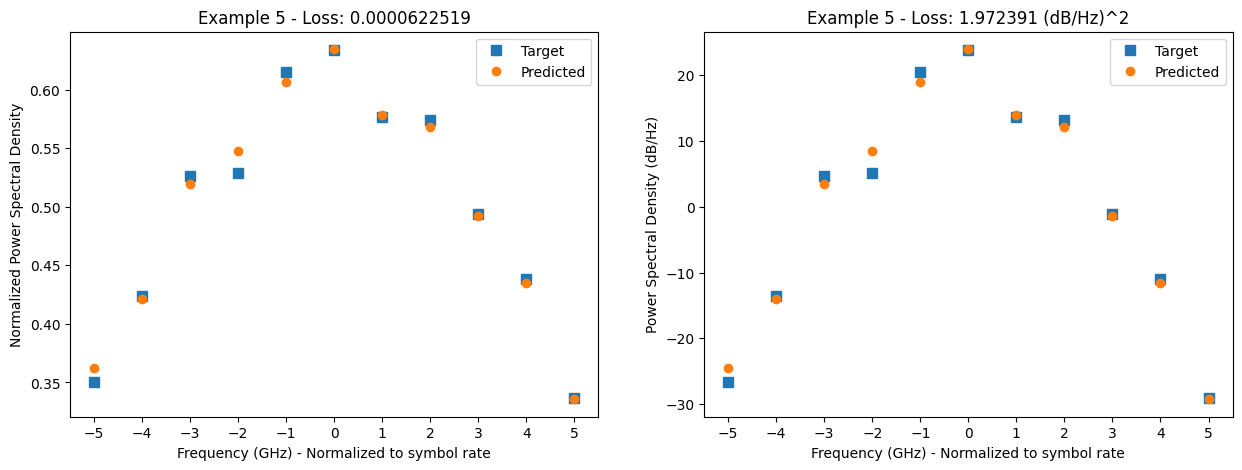

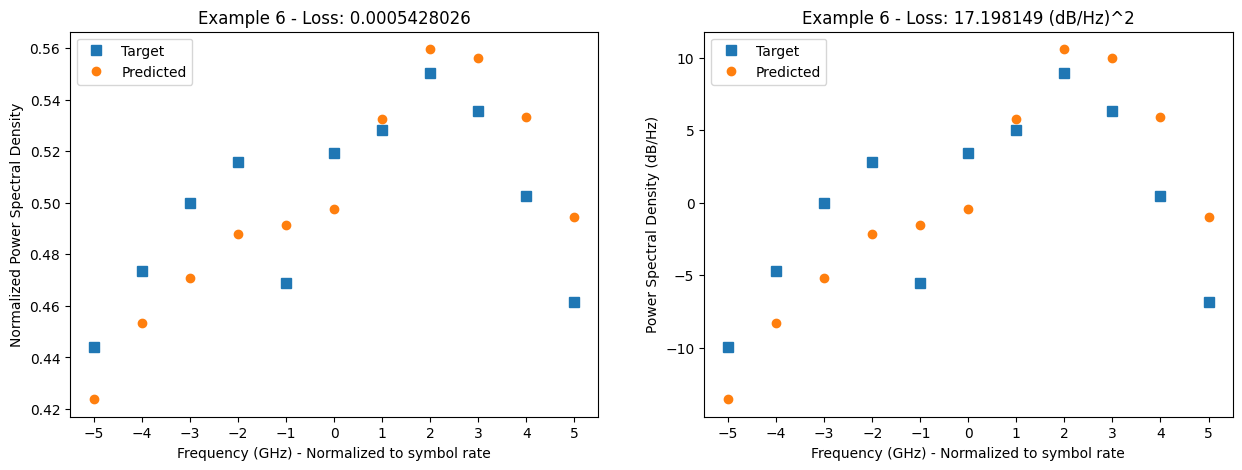

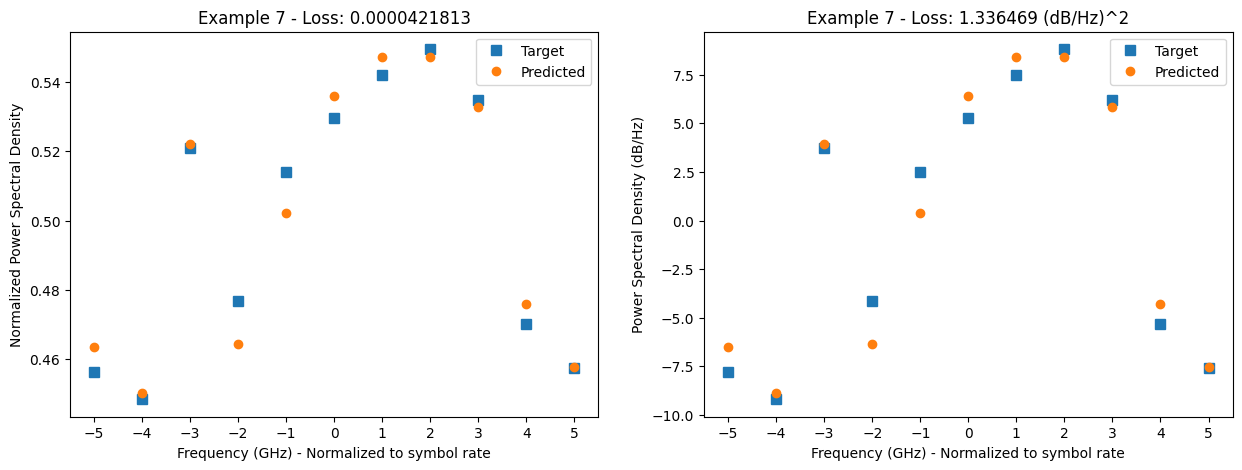

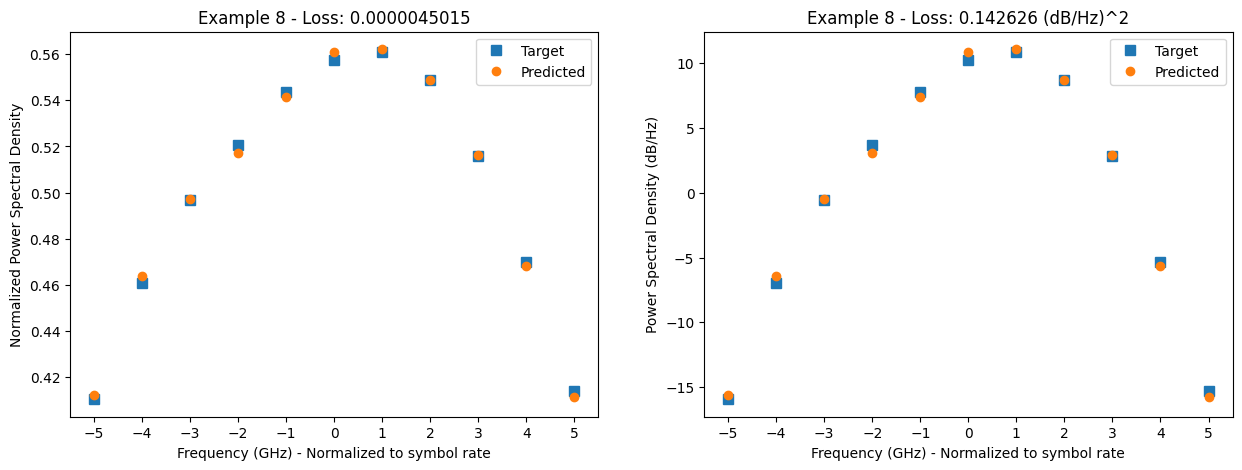

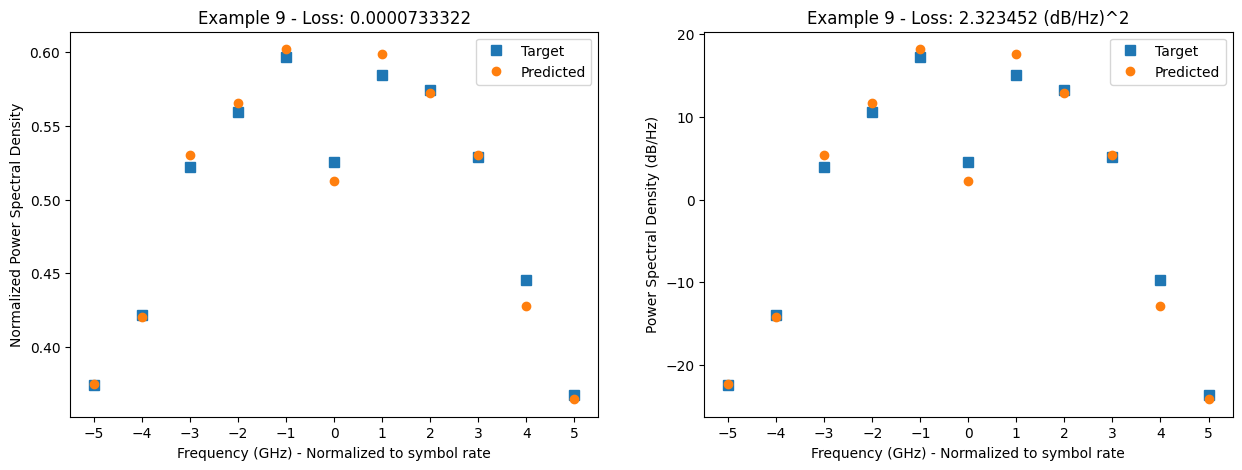

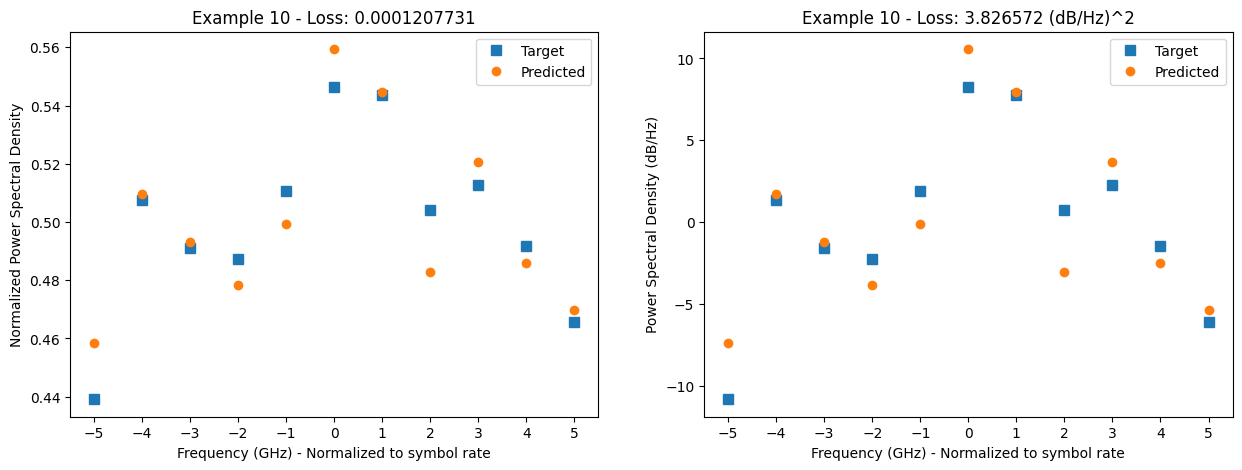

In [76]:
for i in range(min(10, inputs.shape[0])):  # Loop over the first n examples

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),targets[i].cpu().numpy(),"s", label='Target',markersize=7)
    ax[0].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),outputs[i].cpu().numpy(),"o", label='Predicted')
    ax[0].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[0].set_ylabel("Normalized Power Spectral Density")
    ax[0].legend()
    ax[0].set_title(f'Example {i+1} - Loss: {criterion(outputs[i], targets[i]).item():.10f}')

    # Denormalize
    outputs_denorm = train_dataset.denormalize(outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),targets_denorm.cpu().numpy(),"s", label='Target',markersize=7)
    ax[1].plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),outputs_denorm.cpu().numpy(),"o", label='Predicted')
    ax[1].set_xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[1].set_ylabel("Power Spectral Density (dB/Hz)")
    ax[1].legend()
    ax[1].set_title(f'Example {i+1} - Loss: {criterion(outputs_denorm, targets_denorm).item():.6f} (dB/Hz)^2')

## Inverse Network

In [46]:
# Load the pre-trained forward model

forward_model_name = model_name + "val_min.pth"
forward_architecture = [8, 128, 256, 512, 256, 128, 11]
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(torch.load(forward_model_name))  # Load pre-trained weights
#forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases

# Create an inverse model with the same architecture but reversed
inverse_architecture = forward_architecture[::-1]
inverse_net = FrequencyCombNet(inverse_architecture).to(device)

'''
# Initialize the inverse model with the weights and biases of the forward model
forward_params = {name: param for name, param in forward_net.named_parameters()}
i = forward_params.keys().__len__() - 2
for name, param in inverse_net.named_parameters():
    if 'weight' in name:
        param.data = forward_params[f"layers.{i}.weight"].data.t()  # Transpose the weight matrix
    else:
        param.data = forward_params[f"layers.{i}.bias"].data  # Copy the bias
        i=i-2
#'''
# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # lr - learning rate

train_losses = []
val_losses = []

In [ ]:

# Iterate over the layers in the model
for layer_f, layer_i in zip(forward_net.layers, inverse_net.layers):
    # Check if the layer is a linear layer
    if isinstance(layer_f, nn.Linear):
        weight_tensor = layer_f.weight.data
        weight_array_f = weight_tensor.cpu().numpy()

        weight_tensor = layer_i.weight.data
        weight_array_i = weight_tensor.cpu().numpy()
        
        #plot side by side
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].imshow(weight_array_f, cmap='viridis')
        ax[0].set_title('Weights of layer')
        ax[0].set_xlabel('Input Neurons')
        ax[0].set_ylabel('Output Neurons')
        ax[0].set_aspect('auto')
        ax[0].grid(False)

        ax[1].imshow(weight_array_i, cmap='viridis')
        ax[1].set_title('Inverse Weights of layer')
        ax[1].set_xlabel('Input Neurons')
        ax[1].set_ylabel('Output Neurons')
        ax[1].set_aspect('auto')
        ax[1].grid(False)      


In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):

    # Training phase
    inverse_net.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass through the forward model
        with torch.no_grad():
            forward_outputs = forward_net(inputs)
        
        # Forward pass through the inverse model
        inverse_outputs = inverse_net(forward_outputs)

        # Calculate loss
        loss = criterion(inverse_outputs, inputs)
        #loss = criterion(forward_outputs, targets)

        # Backward pass and optimization
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset)  # Calculate average loss over an epoch
    train_losses.append(avg_train_loss)  # Epoch training losses for plotting

    '''
    # Validation phase
    inverse_net.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            outputs = forward_net(inputs)
            inverse_outputs = inverse_net(outputs)
            val_loss = criterion(inverse_outputs, inputs)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # Append average validation loss for the epoch
    '''
    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        #print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {avg_train_loss:.6f}.. Validation Loss: {avg_val_loss:.6f}")
        #plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {avg_train_loss:.6f}..")


In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):

    # Training phase
    forward_net.eval()  # Set model to evaluation mode
    inverse_net.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass through the inverse model
        inverse_outputs = inverse_net(targets)

        # Forward pass through the forward model
        forward_outputs = forward_net(inverse_outputs)

        # Calculate loss
        #loss = criterion(forward_outputs, targets)
        loss = criterion(inverse_outputs, inputs)

        # Backward pass and optimization
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        running_loss += loss.item() * targets.size(0)  # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset)  # Calculate average loss over an epoch
    train_losses.append(avg_train_loss)  # Epoch training losses for plotting

    # Validation phase
    inverse_net.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            outputs = forward_net(inputs)
            inverse_outputs = inverse_net(outputs)
            val_loss = criterion(inverse_outputs, inputs)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {avg_train_loss:.6f}.. Validation Loss: {avg_val_loss:.6f}")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):

    # Training phase
    inverse_net.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, _ in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs = inputs.to(device)

        # Forward pass through the forward model (encoder)
        encoded = forward_net(inputs)

        # Forward pass through the inverse model (decoder)
        decoded = inverse_net(encoded)

        # Calculate loss
        loss = criterion(decoded, inputs)

        # Backward pass and optimization
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset)  # Calculate average loss over an epoch
    train_losses.append(avg_train_loss)  # Epoch training losses for plotting

    # Validation phase
    inverse_net.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            encoded = forward_net(inputs)
            decoded = inverse_net(encoded)
            val_loss = criterion(decoded, inputs)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {avg_train_loss:.6f}.. Validation Loss: {avg_val_loss:.6f}")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")
